## Objective:
Create relationship between the Cabin study data and segments and/or water bodies.

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
# from ipyfilechooser import FileChooser
from geopandas import GeoSeries

import itertools
from operator import itemgetter

import numpy as np

from scipy.spatial import cKDTree

from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString
from pyproj import Proj


## Steps:
- Convert lon and lot from Cabin data to Points
- Use the two functions in `Barrier-Waterbody-segments-connection` file
- Find the closest segment and water body to each study point
- Export the results as CSv for Neo4j

In [2]:
# read study
# create points
st_df = pd.read_csv('data/CABIN-data-20210307/NL_cabin_study_data_mda02_1987-present.csv')
st_df = gpd.GeoDataFrame(
    st_df, geometry=gpd.points_from_xy(st_df.Longitude, st_df.Latitude), crs="EPSG:4326")# crs of waterbodies is 4326

In [3]:
st_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Unnamed: 0                            350 non-null    int64   
 1   Type/Type                             350 non-null    object  
 2   Study/Etude                           350 non-null    object  
 3   StudyDescription/Descriptiondeletude  350 non-null    object  
 4   StudyPurpose/Objectifdeletude         350 non-null    object  
 5   Authority/Autorite                    350 non-null    object  
 6   Province/Province                     350 non-null    object  
 7   Ecoregion/Ecoregion                   350 non-null    object  
 8   EcoregionNumber/Numerodelecoregion    350 non-null    int64   
 9   Site/Site                             350 non-null    object  
 10  SiteName/Nomdusite                    350 non-null    object  
 11

## Study location and segments relationship
Find the closest segment to each study

<AxesSubplot:>

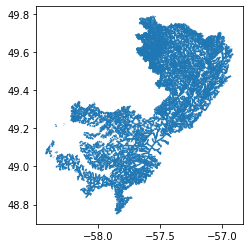

In [4]:
fl_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HN_NLFLOW_1.shp')
fl_df.plot()

# Flatten geo data:
Data from open Canada is 3d, i.e. has a Z component. convert to 2d:

<AxesSubplot:>

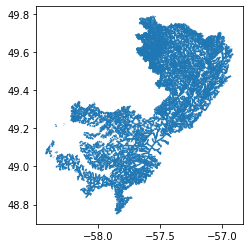

In [5]:
# the data from open canada is 3d meaning it has a Z dimension


def ddd_to_dd_line(g):
    return LineString([xy[0:2] for xy in list(g.coords)]) 

fl_df['geometry'] = fl_df.geometry.apply(lambda x: ddd_to_dd_line(x))
fl_df.plot() 


## Creating segment ID
As the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [6]:
fl_df['row_index'] = fl_df.index
fl_df['row_index'] = fl_df['row_index'].astype('str')
fl_df['segment_id'] = fl_df['DATASETNAM'] + "-" + fl_df.row_index

# Find the closest segment:

In [7]:
# a function for finding the closest point:


def ckdnearesl_line(gdfA, gdfB, gdfB_cols=[], utm_zone = 21):
    """ A is point and B is Linestring
        returns the closest line of gdfB to each point of gdfA and their distance in meters
    """
    gdfA = gdfA.reset_index(drop=True).copy()
    gdfB = gdfB.reset_index(drop=True).copy()
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(np.round(dist,2), name='dist-meters')], axis=1)
    return gdf

In [8]:
# columns to keep from segment dataframe:
fl_cols = ['segment_id'] 

UTM_ZONE = 21
st_fl_nearest_df = ckdnearesl_line( st_df, fl_df, fl_cols, utm_zone = UTM_ZONE)

<ipython-input-7-a4dad5683543>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


In [9]:
st_fl_nearest_df.sort_values('dist-meters')


,Unnamed: 0,Type/Type,Study/Etude,StudyDescription/Descriptiondeletude,StudyPurpose/Objectifdeletude,Authority/Autorite,Province/Province,Ecoregion/Ecoregion,EcoregionNumber/Numerodelecoregion,Site/Site,...,CWSSD_ID,CWSSD_Basin,StreamOrder/Ordreducoursdeau,ENVIRODATCode/Codedenvirodat,JulianDay/JourJulien,Year/Annee,SiteDescription/Descriptiondusite,geometry,segment_id,dist-meters
105,105,River,NL-Newfoundland Labrador Province - Water Reso...,Study managed by the NL Department of the Envi...,Study managed by the NL Department of the Envi...,Provincial,NL,Southwestern Newfoundland,109,NF02YL0098,...,02Y02,Humber,3.0,NF02YL0098,256,2011,"Sampled upstream of culvert on Tamarack Drive,...",POINT (-57.42442 49.29706),02YL000-26202,2.98
32,32,River,NL-ACAP Humber Arm,ACAP Humber Arm - Cornnerbrook,ACAP Humber Arm - Cornnerbrook,NGO,NL,Southwestern Newfoundland,109,RKY01,...,02Y02,Humber,3.0,NF02YL0098,295,2015,This site is located upstream of the first cul...,POINT (-57.42445 49.29705),02YL000-26202,3.10
31,31,River,NL-ACAP Humber Arm,ACAP Humber Arm - Cornnerbrook,ACAP Humber Arm - Cornnerbrook,NGO,NL,Southwestern Newfoundland,109,HGH01,...,02Y02,Humber,3.0,NF02YL0103,294,2015,"Located on Route 440, can be accessed via estu...",POINT (-57.89407 48.99792),02YL000-26219,3.84
26,26,River,NL-ACAP Humber Arm,ACAP Humber Arm - Cornnerbrook,ACAP Humber Arm - Cornnerbrook,NGO,NL,Southwestern Newfoundland,109,BMD01,...,02Y01,Port au Port Bay,4.0,NF02YJ0037,293,2015,Site located on Route 450 upstream of bridge c...,POINT (-58.22440 49.06072),02YL000-27116,5.43
33,33,River,NL-ACAP Humber Arm,ACAP Humber Arm - Cornnerbrook,ACAP Humber Arm - Cornnerbrook,NGO,NL,Southwestern Newfoundland,109,STH01,...,02Y02,Humber,3.0,NF02YL0104,298,2015,"This site is located in Pasadena, and can be a...",POINT (-57.61087 49.01148),02YL000-26272,11.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,283,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,SBC01,...,02Y18,Southern and Eastern Bonavista Bay,3.0,NF02YS0121,305,2018,NaN,POINT (0.00000 0.00000),02YL000-24807,9507753.03
296,296,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,SKB01,...,02Y18,Southern and Eastern Bonavista Bay,2.0,NF02YS0106,298,2018,flows into Sandy Pond on the south side,POINT (0.00000 0.00000),02YL000-24807,9507753.03
297,297,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,SKB01,...,02Y18,Southern and Eastern Bonavista Bay,2.0,NF02YS0106,290,2019,NaN,POINT (0.00000 0.00000),02YL000-24807,9507753.03
314,314,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,SWB03,...,02Y18,Southern and Eastern Bonavista Bay,2.0,NF02YS0103,306,2018,NaN,POINT (0.00000 0.00000),02YL000-24807,9507753.03


Study points are matched with the closest segments to them. Segments are identified by segment_id. The distances between the study locations and the closest segment is stored in the `dist` column.

<AxesSubplot:>

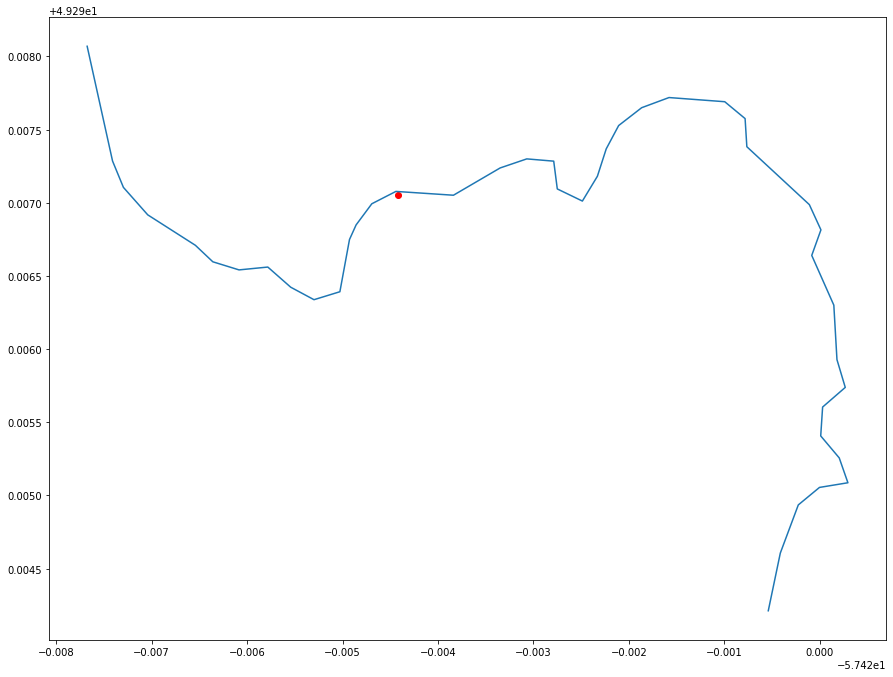

In [10]:
# plot study and segment

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df[fl_df['segment_id'] == '02YL000-26202'].plot(ax=ax)
st_fl_nearest_df.iloc[105:106,:].plot(color='red', ax= ax)

## Save in two formats:
- CSV for database import
- gpkg or shp for keeping the geometry feature intact

In [11]:
st_fl_nearest_df.to_csv('study_to_segments.csv')

In [24]:
# st_fl_nearest_df.to_file("study_to_segments.shp")

<ipython-input-24-801337ef5c4b>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  st_fl_nearest_df.to_file("study_to_segments.shp")


## Study to water body connection:
Repeat the same process for water bodies dataset.

In [12]:
wb_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HD_WATERBODY_2.shp')

In [13]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,LAKEID_2,RIVID_1,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09..."
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73..."
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53..."
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54..."
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21..."


## Creating water body ID
Similar to segments, as the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [16]:
wb_df['row_index'] = wb_df.index
wb_df['row_index'] = wb_df['row_index'].astype('str')
wb_df['waterbody_id'] = wb_df['DATASETNAM'] + "-" + wb_df.row_index

In [17]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry,row_index,waterbody_id
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09...",0,02YL000-0
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73...",1,02YL000-1
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53...",2,02YL000-2
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54...",3,02YL000-3
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21...",4,02YL000-4


In [28]:


def ckdnearesl_poly(gdfA, gdfB, gdfB_cols, utm_zone = 21):
    """ A is point and B is Polygon """
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.exterior]

    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(np.round(dist,2), name='dist-meters')], axis=1)
    return gdf

<AxesSubplot:>

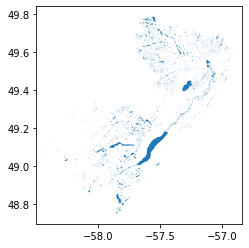

In [29]:
# same as segment, water body data from open canada needs to be 2d

def ddd_to_dd_poly(g):
    return Polygon([xy[0:2] for xy in list(g.exterior.coords)]) 

wb_df['geometry'] = wb_df.geometry.apply(lambda x: ddd_to_dd_poly(x))
wb_df.plot() 


In [30]:
# columns to keep from waterbody dataframe:
wb_cols = ['waterbody_id'] 
st_wb_nearest_df = ckdnearesl_poly(st_df, wb_df, wb_cols, utm_zone = UTM_ZONE)

<ipython-input-28-967fd8fd78ca>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


In [31]:
st_wb_nearest_df.sort_values('dist-meters')

,Unnamed: 0,Type/Type,Study/Etude,StudyDescription/Descriptiondeletude,StudyPurpose/Objectifdeletude,Authority/Autorite,Province/Province,Ecoregion/Ecoregion,EcoregionNumber/Numerodelecoregion,Site/Site,...,CWSSD_ID,CWSSD_Basin,StreamOrder/Ordreducoursdeau,ENVIRODATCode/Codedenvirodat,JulianDay/JourJulien,Year/Annee,SiteDescription/Descriptiondusite,geometry,waterbody_id,dist-meters
26,26,River,NL-ACAP Humber Arm,ACAP Humber Arm - Cornnerbrook,ACAP Humber Arm - Cornnerbrook,NGO,NL,Southwestern Newfoundland,109,BMD01,...,02Y01,Port au Port Bay,4.0,NF02YJ0037,293,2015,Site located on Route 450 upstream of bridge c...,POINT (-58.22440 49.06072),02YL000-7760,1.66
49,49,River,NL-Gros Morne NP,Gros Morne National Park,Gros Morne National Park,Federal-Parks,NL,Long Range Mountains,108,GGB01,...,02Y02,Humber,3.0,NF02YL0092,298,2011,"Long Range- Glanders Gulch, Site code on field...",POINT (-57.58883 49.65564),02YL000-6953,5.97
30,30,River,NL-ACAP Humber Arm,ACAP Humber Arm - Cornnerbrook,ACAP Humber Arm - Cornnerbrook,NGO,NL,Central Newfoundland,112,GLS01,...,02Y02,Humber,3.0,NF02YL0097,295,2015,This location is found on Route 420 upstream o...,POINT (-56.99851 49.54763),02YL000-7776,9.45
50,50,River,NL-Gros Morne NP,Gros Morne National Park,Gros Morne National Park,Federal-Parks,NL,Long Range Mountains,108,HPM01,...,02Y02,Humber,3.0,NF02YL0096,298,2011,"Site code on field sheet = HPMBrk 09, one samp...",POINT (-57.63942 49.62510),02YL000-2642,10.30
69,69,River,NL-Gros Morne NP,Gros Morne National Park,Gros Morne National Park,Federal-Parks,NL,Long Range Mountains,108,SRP01,...,02Y02,Humber,3.0,NF02YL0093,298,2011,"Site code on field sheet= SLPBrk.01, Long Rang...",POINT (-57.52758 49.72778),02YL000-968,11.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,283,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,SBC01,...,02Y18,Southern and Eastern Bonavista Bay,3.0,NF02YS0121,305,2018,NaN,POINT (0.00000 0.00000),02YL000-3571,9507730.63
296,296,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,SKB01,...,02Y18,Southern and Eastern Bonavista Bay,2.0,NF02YS0106,298,2018,flows into Sandy Pond on the south side,POINT (0.00000 0.00000),02YL000-3571,9507730.63
297,297,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,SKB01,...,02Y18,Southern and Eastern Bonavista Bay,2.0,NF02YS0106,290,2019,NaN,POINT (0.00000 0.00000),02YL000-3571,9507730.63
314,314,River,NL-Terra Nova National Park CABIN,"18 sites (10 in 2002, 11 in 2003, 3 sites repe...",Gather baseline data to generate reference con...,Federal-Parks,NL,Central Newfoundland,112,SWB03,...,02Y18,Southern and Eastern Bonavista Bay,2.0,NF02YS0103,306,2018,NaN,POINT (0.00000 0.00000),02YL000-3571,9507730.63


## Save in two formats:
- CSV for database import
- gpkg or shp for keeping the geometry feature intact

In [32]:
st_wb_nearest_df.to_csv('study_to_waterbody.csv')

In [46]:
st_wb_nearest_df.to_file("study_to_waterbody.shp")

<ipython-input-46-53778ef57edc>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  st_wb_nearest_df.to_file("study_to_waterbody.shp")
